## Natural Language Processing with Disaster Tweets

Predict which Tweets are about real disasters and which ones are not

In [1]:
import numpy as np
import pandas as pd
import visualkeras
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import string
import nltk
import keras_tuner

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Embedding, TextVectorization

### 1. Brief description of the problem and data

Form [kagle competition web page](https://www.kaggle.com/competitions/nlp-getting-started), we know that "you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified".

Each sample in the train and test set has the following information:

1. The text of a tweet
2. A keyword from that tweet (although this may be blank!)
3. The location the tweet was sent from (may also be blank)

Reading the csv files, we identify five columns, the three previously mentioned, one more for the target and one for de id. The test dataset has the same columns except for the tarjet column, which is the one we should predict with pur RNN design. 

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [3]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


### 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Inspecting the train dataset, we have a total of 7613 tweets registered. From the plot we confirm that the number of records in each category is not so unbalanced.

In [5]:
train_df.shape

(7613, 5)

<Axes: xlabel='target'>

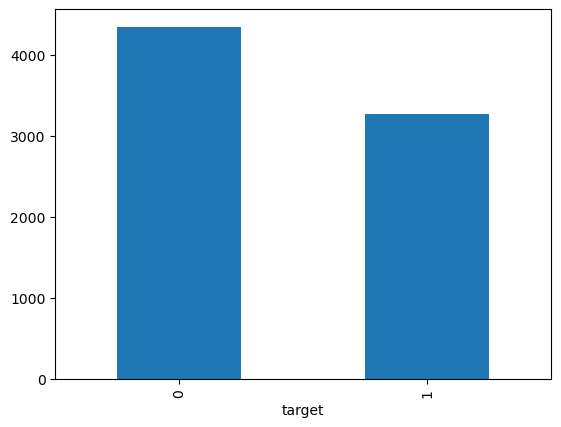

In [6]:
total_train = train_df.groupby("target").count()

total_train["id"].plot.bar()

On the other hand, the data for test are in total 3263 registers, wwhich represents 30% of the dataset of the 10876 registers. 

In [7]:
test_df.shape

(3263, 4)

In [8]:
(3263+7613)

10876

The column _text_ is the core for the analysis. Let's take a look to the data that is not a real disaster.  

In [9]:
train_df[train_df["target"] == 0]["text"].head(20)

15                                       What's up man?
16                                        I love fruits
17                                     Summer is lovely
18                                    My car is so fast
19                         What a goooooooaaaaaal!!!!!!
20                               this is ridiculous....
21                                    London is cool ;)
22                                          Love skiing
23                                What a wonderful day!
24                                             LOOOOOOL
25                       No way...I can't eat that shit
26                                Was in NYC last week!
27                                   Love my girlfriend
28                                            Cooool :)
29                                   Do you like pasta?
30                                             The end!
32    We always try to bring the heavy. #metal #RT h...
34                   Crying out for more! Set me

Now, the data that really is a disaster.

In [10]:
train_df[train_df["target"] == 1]["text"].head(20)

0     Our Deeds are the Reason of this #earthquake M...
1                Forest fire near La Ronge Sask. Canada
2     All residents asked to 'shelter in place' are ...
3     13,000 people receive #wildfires evacuation or...
4     Just got sent this photo from Ruby #Alaska as ...
5     #RockyFire Update => California Hwy. 20 closed...
6     #flood #disaster Heavy rain causes flash flood...
7     I'm on top of the hill and I can see a fire in...
8     There's an emergency evacuation happening now ...
9     I'm afraid that the tornado is coming to our a...
10          Three people died from the heat wave so far
11    Haha South Tampa is getting flooded hah- WAIT ...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
13              #Flood in Bago Myanmar #We arrived Bago
14    Damage to school bus on 80 in multi car crash ...
31    @bbcmtd Wholesale Markets ablaze http://t.co/l...
33    #AFRICANBAZE: Breaking news:Nigeria flag set a...
37    INEC Office in Abia Set Ablaze - http://t.

In [11]:
test_df["text"].head(20)

0                    Just happened a terrible car crash
1     Heard about #earthquake is different cities, s...
2     there is a forest fire at spot pond, geese are...
3              Apocalypse lighting. #Spokane #wildfires
4         Typhoon Soudelor kills 28 in China and Taiwan
5                    We're shaking...It's an earthquake
6     They'd probably still show more life than Arse...
7                                     Hey! How are you?
8                                      What a nice hat?
9                                             Fuck off!
10                                No I don't like cold!
11                           NOOOOOOOOO! Don't do that!
12                               No don't tell me that!
13                                            What if?!
14                                             Awesome!
15    Birmingham Wholesale Market is ablaze BBC News...
16    @sunkxssedharry will you wear shorts for race ...
17    #PreviouslyOnDoyinTv: Toke MakinwaÛªs mar

In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
def custom_filter(content):
    text = re.sub(r"\bhttp"," ",content)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = re.sub("\d"," ",text)
    text = re.sub("\W"," ",text)
    text = text.lower()
    text = text.translate(str.maketrans("","", string.punctuation))
    text = text.split()
    text = [word for word in text if not word in stop_words]
    text = ' '.join(filter(str.isalpha, text))
    return text



In [13]:
train_df['text']= train_df['text'].apply(custom_filter)
test_df['text']= test_df['text'].apply(custom_filter)

In [14]:
train_df[train_df["target"] == 0]["text"].head(20)

15                                                  man
16                                          love fruits
17                                        summer lovely
18                                             car fast
19                                      goooooooaaaaaal
20                                           ridiculous
21                                          london cool
22                                          love skiing
23                                        wonderful day
24                                             looooool
25                                         way eat shit
26                                        nyc last week
27                                      love girlfriend
28                                               cooool
29                                           like pasta
30                                                  end
32        always try bring heavy metal rt co yao e xngw
34                                    crying set

In [15]:
train_df[train_df["target"] == 1]["text"].head(20)

0          deeds reason earthquake may allah forgive us
1                 forest fire near la ronge sask canada
2     residents asked shelter place notified officer...
3     people receive wildfires evacuation orders cal...
4     got sent photo ruby alaska smoke wildfires pou...
5     rockyfire update california hwy closed directi...
6     flood disaster heavy rain causes flash floodin...
7                               top hill see fire woods
8     emergency evacuation happening building across...
9                            afraid tornado coming area
10                      three people died heat wave far
11    haha south tampa getting flooded hah wait seco...
12    raining flooding florida tampabay tampa days l...
13                      flood bago myanmar arrived bago
14           damage school bus multi car crash breaking
31        bbcmtd wholesale markets ablaze co lhyxeohy c
33    africanbaze breaking news nigeria flag set abl...
37             inec office abia set ablaze co im

In [16]:
test_df["text"].head(20)

0                           happened terrible car crash
1     heard earthquake different cities stay safe ev...
2     forest fire spot pond geese fleeing across str...
3                 apocalypse lighting spokane wildfires
4                   typhoon soudelor kills china taiwan
5                                    shaking earthquake
6      probably still show life arsenal yesterday eh eh
7                                                   hey
8                                              nice hat
9                                                  fuck
10                                            like cold
11                                           nooooooooo
12                                                 tell
13                                                     
14                                              awesome
15    birmingham wholesale market ablaze bbc news fi...
16               sunkxssedharry wear shorts race ablaze
17    previouslyondoyintv toke makinwa marriage 

### 3. Model Architecture 

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

Unlike last week's use of images, text processing tends to be more complicated. We must transform the text strings into something that the computer can understand. According to [Word Embedding Techniques: Word2Vec and TF-IDF Explained](https://towardsdatascience.com/word-embedding-techniques-word2vec-and-tf-idf-explained-c5d02e34d08), "the word embedding techniques are used to represent words mathematically". We can use techniques like:
1. One Hot Encoding
2. TF-IDF
3. Word2Vec
4. FastText

The algorithm that seems most convenient for the type of classification we want to carry out is to convert form a string to a vector, like in the Word2Vec. This is because we can create a vocabulary from the same raw text inputs and use this vocabulary to create a vector. This allow us to evaluate the semantic closeness of the words. We are going to use the TextVetorization laker from keras. But first, we have to build our train, validation and test data. We shuffle the samples from the train set and the labels, using the same seed. Also we have to splitting the train set further into validation and new train sets. 


In [17]:
samples = train_df["text"]
labels = train_df["target"]
test_samples = test_df["text"]

train_samples, val_samples, train_targets, val_targets = train_test_split(
        samples, labels,
        train_size=0.8,
        random_state=42,
        shuffle = True,
        stratify=labels
    )



We use a 20% spliting factor. We have 6090 registers for training and 1523 for validation. For test and sumission results we have 3263 samples.

In [18]:
train_samples.shape

(6090,)

In [19]:
val_samples.shape

(1523,)

In [20]:
test_samples.shape

(3263,)

We transform the data to tensor dataset to optimize the process

In [21]:
batch_size=20

train_data= tf.data.Dataset.from_tensor_slices((train_samples.to_numpy(), train_targets.to_numpy())) 
val_data = tf.data.Dataset.from_tensor_slices((val_samples.to_numpy(),val_targets.to_numpy()))
test_data = tf.data.Dataset.from_tensor_slices((test_samples.to_numpy()))
train_all = tf.data.Dataset.from_tensor_slices((samples.to_numpy(), labels.to_numpy()))

train_data = train_data.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_all = train_all.batch(batch_size).prefetch(tf.data.AUTOTUNE)

We can inspect some of the samples. 

In [22]:
for text,label in train_data.take(1):
    print('Text: ',text.numpy())
    print('Label: ',label.numpy())

Text:  [b'x counter acts burning alexandrian library'
 b'bigamist first wife charged deaths second pregnant wife child mothe co rteugb tnv'
 b'mickinyman theatlantic might killed airplane accident night car wreck politics best'
 b'breaking firefighters battling blaze east cary condo building co mim hh ce'
 b'thinking time friend bailed nite b dead show went alone amp great time alone free dance front row'
 b'kiranahmedd us military nato fighting talibans'
 b'secrets storm vortex lightning catcher book co oiywrzl z'
 b'hail user summons hailstorm lasting five turns damages pokemon except ice type'
 b'lets collide untill fill space' b'taaylordarr thank survived'
 b'notley tactful yet direct response harper attack alberta gov hell yeah premier co rzsulzmokx ableg cdnpoli'
 b'coming later year man tattooed women novel based real serial killer arkansas amp natural disaster nola'
 b'next financial crash writing wall say warned co h ldx aba'
 b'doves storm greatest denier electric proms pt co

We create our Textvectorization layer. Let´s see the percentile estimate for the train set. The recommendation from keras documentation is that a good enough approximate for the maximum sequence length, is the 50% value. In these case we have a maximun sequence of 15. 

In [23]:
train_df["text"].apply(lambda x: len(x.split(" "))).describe()

count    7613.000000
mean       10.952712
std         4.045897
min         1.000000
25%         8.000000
50%        11.000000
75%        14.000000
max        25.000000
Name: text, dtype: float64

Next step, define the vectorization layer. 

In [24]:
max_len = 15
max_features = 20000 

vectorize_layer = TextVectorization(
    max_tokens = max_features, 
    output_mode = "int", 
    output_sequence_length = max_len)

#vectorize_layer.adapt(train_data.map(lambda text, label: text))
vectorize_layer.adapt(train_df["text"])  #using all train dataset.

We can visualize the first word fo our vocabulary.

In [25]:
vectorize_layer.get_vocabulary()[:10]


['', '[UNK]', 'co', 'like', 'amp', 'fire', 'get', 'new', 'via', 'u']

Load pre-trained word embeddings

For the vectorization, we apply it to the text dataset to obtain a dataset of word indices, then feed it into a model that expects integer sequences as input, according to recommendation of [keras guide](https://keras.io/examples/nlp/text_classification_from_scratch/) for asynchronous CPU processing and buffering.

In [26]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds =train_data.map(vectorize_text)
val_ds = val_data.map(vectorize_text)
all_ds = train_all.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
all_ds = all_ds.cache().prefetch(buffer_size=10)

In [27]:
for text,label in train_ds.take(1):
    print('Text: ',text.numpy())
    print('Label: ',label.numpy())

Text:  [[ 2142   481   514  1976   570  1533  1822   870  1144     0     0     0
      0     0     0]
 [  119  1262   144   535  2508   336  1433   520  2756     2 15043    30
   1939     0     0]
 [  528  2779 19340     5  1033   192  1451   192     2  3297 16857     0
      0     0     0]
 [  570 13042 12277   296 11514 19539  1007  1541  1473   912  4370    69
    729   171   224]
 [    1   135   691   549  2908   509  2908 18383   892 16013   150     0
      0     0     0]
 [ 1911   123   706 15085  4589   567     2 17625 17118     0     0     0
      0     0     0]
 [ 9321   455   826   294   554  1957    40  6143   912  2503  8995     0
      0     0     0]
 [ 2789  4598   412    48  5696   323   220     1     2  3222 18771     0
      0     0     0]
 [  881  2241  2113   714    50    16   295     2  8782     8  2142     0
      0     0     0]
 [ 1142    87  2417     3  1018 19558   313 15994   224  2081 19121     1
     20  1108     0]
 [  446  2460   381   956 12912  1475   271

We can build our model, using some the recommendation from the book __Advanced Deep Learning with TensorFlow 2 and Keras__ from _Rowel Atienza_. First we use a simple RNN.

In [29]:
embedding_dim = 128
units = 128

model = Sequential()
model.add(tf.keras.Input(shape=(max_len,), dtype="int64"))
model.add(Embedding(input_dim = max_features + 1, output_dim = embedding_dim, input_length = max_len))
model.add(LSTM(units=units))
model.add(Dense(500, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))          



In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 128)           2560128   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 500)               64500     
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 501       
                                                                 
Total params: 2,756,713
Trainable params: 2,756,713
Non-trainable params: 0
_________________________________________________________________


We have to prepare our data for model fit. 

In [31]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


### 4. Results and Analysis

We fit our first model. 

In [32]:
hist = model.fit(train_ds, batch_size=batch_size, epochs=10, validation_data=val_ds)

Epoch 1/10
305/305 [==============================] - 17s 21ms/step - loss: 0.5133 - accuracy: 0.7502 - val_loss: 0.4377 - val_accuracy: 0.8050
Epoch 2/10
305/305 [==============================] - 5s 18ms/step - loss: 0.2332 - accuracy: 0.9095 - val_loss: 0.5502 - val_accuracy: 0.7833
Epoch 3/10
305/305 [==============================] - 6s 18ms/step - loss: 0.0946 - accuracy: 0.9677 - val_loss: 0.8625 - val_accuracy: 0.7702
Epoch 4/10
305/305 [==============================] - 5s 17ms/step - loss: 0.0773 - accuracy: 0.9755 - val_loss: 0.7599 - val_accuracy: 0.7557
Epoch 5/10
305/305 [==============================] - 5s 16ms/step - loss: 0.0680 - accuracy: 0.9768 - val_loss: 0.7692 - val_accuracy: 0.7663
Epoch 6/10
305/305 [==============================] - 5s 17ms/step - loss: 0.0499 - accuracy: 0.9862 - val_loss: 0.8817 - val_accuracy: 0.7814
Epoch 7/10
305/305 [==============================] - 6s 18ms/step - loss: 0.0404 - accuracy: 0.9888 - val_loss: 0.8988 - val_accuracy: 0.784

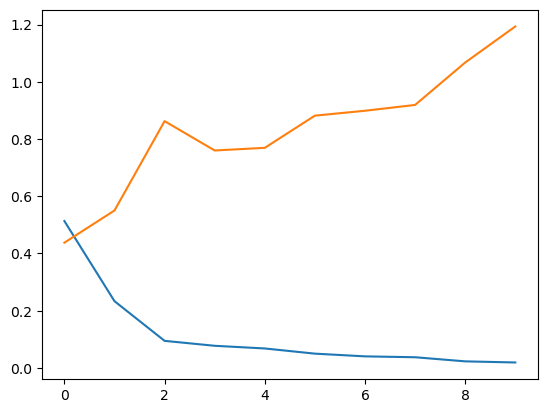

In [33]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])



In [35]:
model.evaluate(val_ds)

## Best result: 0.7623

77/77 [==============================] - 1s 14ms/step - loss: 1.1933 - accuracy: 0.7623


[1.193300485610962, 0.7623112201690674]

For the hyperparameter tuning, we are going to use the [KerasTuner](https://keras.io/guides/keras_tuner/getting_started/). The first thing we need to do is writing a function, which returns a compiled Keras model. It takes an argument _hp_ for defining the hyperparameters while building the model. We use the next parameters:
1. Embedding dimension for the enbedding layer.
2. Number of units in the LSTM layer. 
3. Number of Dense layers.
4. Units for each of the dense layers.
5. Dropout rate.
6. learnig rate for the optimizer

In [36]:
def build_model(hp):
    model = Sequential()
    model.add(tf.keras.Input(shape=(max_len,), dtype="int64"))
    model.add(Embedding(
        input_dim = max_features + 1, 
        output_dim = hp.Int("embedding_dim", min_value=15, max_value=150, step=15),
        input_length = max_len))
    model.add(LSTM(units=hp.Int("units", min_value=32, max_value=512, step=32)))
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation="relu"
            )
        )
    model.add(Dropout(rate=hp.Float("rate", min_value=0, max_value=0.5, step=0.1)))
    model.add(Dense(1,activation='sigmoid'))   
    model.compile(
        loss="binary_crossentropy", 
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
        metrics=["accuracy"])
    return model

Check if the model builds successfully.

In [37]:
build_model(keras_tuner.HyperParameters())

After defining the search space, we need to select a tuner class to run the search. We choose RandomSearch for start the search. For the first optimization we observe that a epoch of 3 is enough to obtain good results. 

In [38]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory="models", 
    project_name="RNNAssigment" 
)

tuner.search_space_summary()


Search space summary
Default search space size: 6
embedding_dim (Int)
{'default': None, 'conditions': [], 'min_value': 15, 'max_value': 150, 'step': 15, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [39]:
tuner.search(train_ds, epochs=2, validation_data=val_ds)

Trial 20 Complete [00h 00m 19s]
val_accuracy: 0.7971109747886658

Best val_accuracy So Far: 0.8102429509162903
Total elapsed time: 00h 06m 00s
INFO:tensorflow:Oracle triggered exit


Let's see the best model. 

In [40]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, max_len))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 90)            1800090   
                                                                 
 lstm (LSTM)                 (None, 256)               355328    
                                                                 
 dense (Dense)               (None, 384)               98688     
                                                                 
 dense_1 (Dense)             (None, 256)               98560     
                                                                 
 dense_2 (Dense)             (None, 352)               90464     
                                                                 
 dropout (Dropout)           (None, 352)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

With the best hyperparameters we build the model again, fitting with the entire dataset.

In [41]:
best_hps = tuner.get_best_hyperparameters(5)
model = build_model(best_hps[0])
hist = model.fit(all_ds, epochs=10)

Epoch 1/10
381/381 [==============================] - 10s 18ms/step - loss: 0.6210 - accuracy: 0.6532
Epoch 2/10
381/381 [==============================] - 7s 17ms/step - loss: 0.3430 - accuracy: 0.8589
Epoch 3/10
381/381 [==============================] - 7s 17ms/step - loss: 0.1716 - accuracy: 0.9368
Epoch 4/10
381/381 [==============================] - 7s 18ms/step - loss: 0.1316 - accuracy: 0.9574
Epoch 5/10
381/381 [==============================] - 7s 18ms/step - loss: 0.0861 - accuracy: 0.9727
Epoch 6/10
381/381 [==============================] - 7s 18ms/step - loss: 0.0556 - accuracy: 0.9813
Epoch 7/10
381/381 [==============================] - 7s 17ms/step - loss: 0.0505 - accuracy: 0.9846
Epoch 8/10
381/381 [==============================] - 7s 19ms/step - loss: 0.0473 - accuracy: 0.9875
Epoch 9/10
381/381 [==============================] - 7s 19ms/step - loss: 0.0390 - accuracy: 0.9892
Epoch 10/10
381/381 [==============================] - 7s 19ms/step - loss: 0.0320 - accur

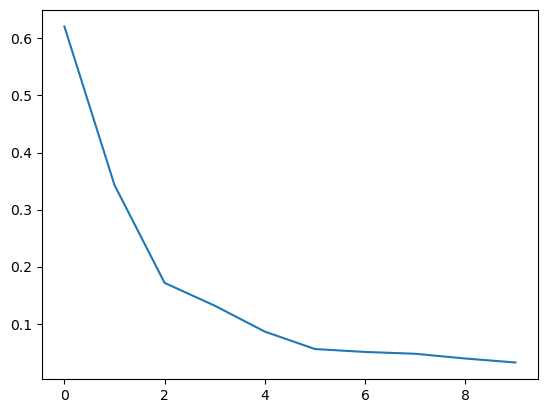

In [42]:
plt.plot(hist.history['loss'])

With this results, we have to find our first submission. We need to make a end to end model to compute the prediction from the test samples, using [keras guide recommendations](https://keras.io/examples/nlp/text_classification_from_scratch/).

In [43]:
# A string input
inputs = tf.keras.Input(shape=(1,), dtype="string")
# Turn strings into vocab indices
indices = vectorize_layer(inputs)
# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)


In [44]:
predictions = end_to_end_model.predict(test_df["text"])

102/102 [==============================] - 2s 15ms/step


In [45]:
submission_files = pd.read_csv("data/sample_submission.csv")
tweet_id = submission_files["id"]
final_predictions = np.transpose(np.where(predictions>0.5,1,0))[0]
submission = pd.DataFrame(list(zip(tweet_id,final_predictions)), columns=["id", "target"])
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


Finally, we have to prepare the submission file to compare our results with other competition results.

In [46]:
submission.to_csv('data/submission.csv', index=False)

### 5. Conclusion

Once the results were sent to the competition, we obtained the following results:

![](images/submission.png)

The position 982 is still very low compared to what was achieved by most of the participants,  so the proposed architecture must be improved. Although a hyperparameter optimization process was developed, the improvement in results was marginal. It is posible that we need to use to train a text classification model that uses pre-trained word embeddings like the GloVe embeddings.

### 6. Github Repository

[https://github.com/alezulu73/RNNWeek4Assigment](https://github.com/alezulu73/RNNWeek4Assigment)